**Navn på gruppens medlemmer:** Jostein Kløgetvedt og Alexander Ohrt

# Om de numeriske øvingene i kvantemekanikk

Målet med de numeriske øvingene i kvantemekanikk er
* å bruke numeriske metoder og visualiseringer for å forstå kvantemekanikk bedre.
* å utvikle en generell "verktøykasse" du kan bruke også når du arbeider med andre øvinger og lærer nytt stoff i faget.
* å se ligningene i kvantemekanikken og løsninger av disse fra et generelt perspektiv.
* å utvikle ferdigheter innen programmering og numerikk.

Vi legger opp til bruk av Python sammen med bibliotekene `numpy`, `scipy` og `matplotlib` for numerikk, vitenskapelige beregninger og plotting.
*Bruk disse for alt de er verdt!*
God bruk av disse bibliotekene vil la deg uttrykke deg mer konsist enn om du kun bruker standard Python-funksjonalitet.
Vi forventer at du selv finner fram til relevant funksjonalitet og dokumentasjon i bibliotekene.
De er alle godt dokumentert på Internett.

I Jupyter Notebook og Jupyter Lab er det mulig å bruke ulike *backends* for plotting med `matplotlib`.
Dette er grovt forklart forskjellige underliggende "motorer" som bestemmer utseende og funksjonaliteten til figurene som produseres.
Avhengig av hvilket av programmene du bruker, vil du erfare at en backend fungerer bedre enn andre.
I Jupyter Notebook fungerer `notebook`-backenden best og uten behov for installasjon av ekstra programvare, men i Jupyter Lab må tillegget [jupyter-matplotlib](https://github.com/matplotlib/jupyter-matplotlib) installeres for å få den optimale `widget`-backenden til å fungere.
Begge programmene støtter også `inline`-backenden uten behov for tilleggsprogramvare, men denne produserer mindre fleksible figurer og bør kun brukes som reserveløsning.
Prøv deg selv fram med backendene foreslått under for å finne den som fungerer best for deg.

In [1]:
# uncomment ONE line to choose matplotlib backend
# if using Jupyter Notebook, use interactive "notebook" backend for best results
# if using Jupyter Lab, use interactive "widget" backend for best results
# if both fail, use static "inline" backend
#matplotlib notebook 
#%matplotlib widget 
#%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
%matplotlib inline

## Kort om fysiske enheter i numeriske beregninger

I numeriske beregninger må vi ta hensyn til den begrensede presisjonen og størrelsen til flyttallene som datamaskinen bruker for å representere relle tall.
I kvantemekanikken møter vi spesielt ofte på Plancks reduserte konstant $\hbar \approx 6.63 \cdot 10^{-34} \text{ Js}$ og gjerne kvadratet $\hbar^2$. Det er i utgangspunktet ingenting i veien for å benytte SI-enheter for alle størrelser som opptrer i disse øvingene. Et alternativ er å benytte [atomære enheter](https://en.wikipedia.org/wiki/Hartree_atomic_units).
Dette enhetssystemet er skreddersydd for beregninger på atomært nivå.
Her er blant annet $\hbar$, elektronmassen $m_e$ og elementærladningen $e$ *definert* til å ha tallverdi $1$.
For eksempel uttrykkes energier som multipler av én hartree, $E_h = \hbar^2 / m_e a_0^2 \approx 4.36 \cdot 10^{-18} \text{ J}$. En annen løsning er å benytte enheter som $\text{nm}$ og $\text{eV}$ for lengder og energier. En hartree tilsvarer ca. 27.2 eV, dvs. det dobbelte av grunntilstandsenergien i hydrogenatomet.

**Velg selv hensiktsmessige enheter til bruk i beregningene, men vær oppmerksom på den begrensede presisjonen til flyttall!**

# Numerisk løsning av den tidsuavhengige Schrödingerligningen

Å løse den tidsuavhengige Schrödingerligningen
$$ \hat{H} \psi = -\frac{\hbar^2}{2 m} \psi'' + V \psi = E \psi, $$
dvs. å bestemme energiegenverdier $E$ og tilhørende energiegenfunksjoner $\psi(x)$ for et gitt potensial $V(x)$, er et sentralt problem i kvantemekanikken. Dette er ofte ingen enkel oppgave.
Selv for potensialer som gir ligningen analytiske løsninger, kreves det ofte betydelig innsats og bruk av spesielle teknikker for å komme fram til disse.
Vi skal her se på en elegant og generell teknikk for å løse ligningen numerisk for et vilkårlig potensial (i én dimensjon).

Numeriske løsningsmetoder innebærer alltid en viss avgrensning og diskretisering for å gjøre problemet endelig og håndterlig for en datamaskin. Vi avgrenser her delen av rommet vi ser på til å ligge mellom to endepunkter $x_0$ og $x_{N+1}$ og deler opp intervallet mellom dem i punktene $x_0, x_1, \ldots, x_N, x_{N+1}$ med lik avstand $\Delta x$ mellom hvert punkt.
Utenfor dette området definerer vi potensialet til $V(x \leq x_0) = V(x \geq x_{N+1}) = \infty$, slik at $\psi(x \leq x_0) = \psi(x \geq x_{N+1}) = 0$ og det kun er bølgefunksjonens verdier på rutenettet $\boldsymbol{x} = [x_1, \ldots, x_N]^T$ som er ukjente og av interesse.
Til hvert punkt tilordner vi verdiene $\psi_i = \psi(x_i)$ og $V_i = V(x_i)$ til energiegenfunksjonene og potensialet, og vi refererer til verdiene av funksjonene i alle punktene ved hjelp av vektorene $\boldsymbol{V} = [V_1, \ldots, V_N]^T$ og $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.

En intuitiv og enkel tilnærming av den deriverte til en funksjon er den sentrale differansen
$$ \psi'(x) = \frac{\psi(x + \Delta x / 2) - \psi(x - \Delta x / 2)}{\Delta x} $$
Om vi bruker denne tilnærmingen to ganger, kan vi også tilnærme den andrederiverte som
$$ \psi''(x) = \frac{\psi'(x + \Delta x / 2) - \psi'(x - \Delta x / 2)}{\Delta x} = \frac{\psi(x + \Delta x) - 2 \psi(x) + \psi(x - \Delta x)}{\Delta x^2}$$

Ved å sette denne tilnærmingen inn i den tidsuavhengige Schrödingerligningen, kan vi tilnærme den numerisk som
$$-\frac{\hbar^2}{2 m} \frac{\psi_{i+1} - 2 \psi_i + \psi_{i-1}}{{\Delta x}^2} + V_i \psi_i = E \psi_i \qquad \text{for}\,\, i = 1, 2, \ldots, N$$

Vi kan uttrykke denne ligningen på en elegant måte ved å innføre $N \times N$-Hamiltonmatrisen $H$ med elementer
$$ H_{i j} = \begin{cases} 
    \hbar^2 / (m \Delta x^2) + V_i & \text{for} \,\, i = j         & \text{(på diagonalen)}        \\ 
    -\hbar^2 / (2 m \Delta x^2)    & \text{for} \,\, i = j \pm 1   & \text{(på semidiagonalene)}   \\
    0                              & \text{ellers}                                                 \\
\end{cases} $$
og benytte oss av vektoren $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.
Den tar da formen
$$ H \boldsymbol{\psi} = E \boldsymbol{\psi} $$
Energiene $E$ og energiegenfunksjonene $\boldsymbol{\psi}$ er dermed egenverdier og egenvektorer til matrisen $H$!

Numerikkbiblioteker har funksjonalitet for å finne egenverdier og egenvektorer til vilkårlige matriser.
De har gjerne også spesialiserte funksjoner som gjør dette mer effektivt for matriser med en spesiell form, for eksempel som den *tridiagonale* (samt reelle og symmetriske) formen til matrisen $H$.

**Skriv en funksjon som beregner og returnerer alle energiegenverdier $E$ og tilhørende energiegenfunksjoner $\boldsymbol{\psi}$ for en partikkel med masse $m$ som befinner seg i et gitt potensial $\boldsymbol{V}$ på rutenettet $\boldsymbol{x}$. Normér energiegenfunksjonene i forstanden $\int |\psi|^2 \mathrm{d}x$ = 1.**

In [2]:
L = 1             #L=length of the x-axis
N = 200           #N=amount of x-coordinates
dx = L/(N+1)
h_bar = 1.05E-34     
m=9.11E-31          

#x_0 = 0 and x_N+1 = L
x = np.array([n*dx for n in range(1,N+1)])


def solve_TUSL(V):
    V_list = [V(x_i) for x_i in x]
    hamilton_diagonal = [h_bar**2/(m*dx**2) + v for v in V_list]
    hamilton_semi_diagonal = [-h_bar**2/(2*m*dx**2) for i in range(len(V_list)-1)]
    w, psi = eigh_tridiagonal(hamilton_diagonal, hamilton_semi_diagonal)
    eigenvalues = w/(1.60e-19)
    return eigenvalues, psi

def normalize(psi):
    for i in range(len(psi)):
        norm = np.sqrt(np.sum(psi[:,i]**2))
        psi[:,i] = psi[:,i]/(norm)
    return psi*14       #magic constant
 
def check_norm_psi(psi_i):
    return np.sum(np.abs(psi_i)**2)*dx

def eigenvalues_ratio(n, eigenvalues):
    first = eigenvalues[0]
    print("Ratio between the E_i and E_0: ")
    for i in range(1,n+1):
        print(round(eigenvalues[i]/first,2), " number ", i)

I resten av øvingen skal vi rett og slett bare bruke denne numeriske løsningsmetoden på en rekke forskjellige potensialer.
I noen av eksemplene skal vi også sammenligne de numeriske verdiene med analytiske resultater.
For å gjøre denne prosessen så enkel som mulig, foreslår vi at du her skriver én "ultimat" plottefunksjon som du kan gjenbruke i alle disse oppgavene.

**Skriv en funksjon som framstiller potensialet $\boldsymbol{V}$, energiegenverdier $E$ og energiegenfunksjoner $\boldsymbol{\psi}$ (eller absoluttkvadratene $|\boldsymbol{\psi}|^2$) på rutenettet $\boldsymbol{x}$ grafisk. Funksjonen skal også kunne brukes til å sammenligne to sett med (numeriske og analytiske) energier og energiegenfunksjoner.**

**Gjør gjerne dette parallelt med resten av oppgavene, slik at du kan tilpasse framstillingen basert på behovene som oppstår. Se gjerne i forelesningsnotater, bøker og søk rundt på Internett for å få litt inspirasjon til hvordan framstillingen kan gjøres.**

In [3]:
def plotting(eigenvalues, psi, label, number):
    if "Analytic" in label:
        for i in range(number):
            plt.plot(x,psi(i,x), label=r"$\psi :$" + str(i+1))
            plt.title(label)
            plt.legend()
        plt.show()
        for i in range(number):
            E = []
            plt.ylabel("eV")
            E = np.array([eigenvalues(i) for l in range(len(x))])
            plt.plot(x, E, label="E:"+str(i+1))
            plt.title(label)
            plt.legend()
        plt.show()
    else:
        for i in range(number):
            psi_i = psi[:,i]
            plt.plot(x,psi_i, label=r"$\psi :$" + str(i+1))
            plt.title(label)
            plt.legend()
        plt.show()
        for i in range(number):
            E = []
            plt.ylabel("eV")
            E = np.array([eigenvalues[i] for l in range(len(x))])
            plt.plot(x, E, label="E:"+str(i+1))
            plt.title(label)
            plt.legend()
        plt.show()        

## Partikkel i boks

Et av de første kvantemekaniske problemene vi støter på er partikkel i boks.
Her er potensialet, de normerte energiegenfunksjonene og energiegenverdiene
$$
V(x) = \begin{cases}0 & \text{for}\,\, 0 \leq x \leq L \\ \infty & \text{ellers} \end{cases},
\quad \psi(x) = \sqrt{\frac{2}{L}} \sin{\frac{n \pi x}{L}}, 
\quad E = \frac{n^2 \pi^2 \hbar^2}{2 m L^2},
\quad \quad n = 1, 2, \ldots,
$$

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner for et elektron i en boks grafisk.**

**Hvordan er spredningen i energinivåene?**

Particle in box

0.9751243781094528 	 Normalized
Comparing numrical eigenvalues
Ratio between the E_i and E_0: 
4.0  number  1
9.0  number  2
16.0  number  3
24.99  number  4


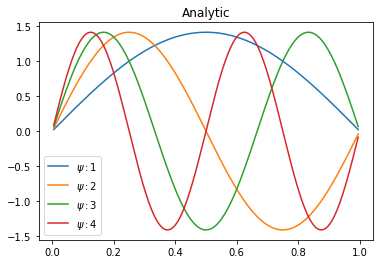

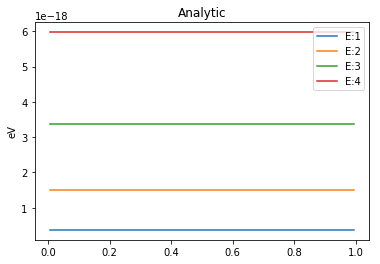

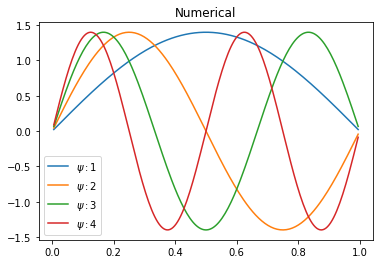

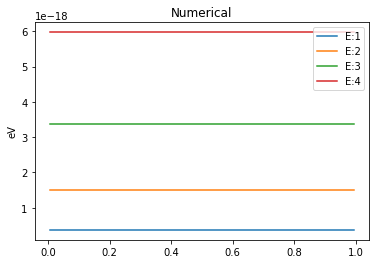

In [378]:
def psi_PIB_an(n,x):
    return np.sqrt(2/L) * np.sin(((n+1-0)*np.pi*x)/L)

def E_PIB_an(n):
    return ((n+1)**2 * np.pi**2 * h_bar**2)/(2*m*L*1.60e-19)   #eV

def V_box(x):   #box-potential, psi is zero when V=inf.
    return 0

eigenvalues_PIB, psi_PIB = solve_TUSL(V_box)
psi_PIB = normalize(psi_PIB)
print("Particle in box\n")
print(check_norm_psi(psi_PIB[:,0]), "\t Normalized")
print("Comparing numrical eigenvalues")
eigenvalues_ratio(4,eigenvalues_PIB)

plotting(E_PIB_an, psi_PIB_an, "Analytic", 4)
plotting(eigenvalues_PIB, psi_PIB, "Numerical", 4)

## Harmonisk oscillator

Et annet standard kvantemekanisk problem er den harmoniske oscillatoren med
$$
V(x) = \frac{1}{2}m \omega^2 x^2,
\quad \psi(x) = \frac{1}{\sqrt{2^n n!}} \cdot \left(\frac{m \omega}{\pi \hbar}\right)^{1/4} \cdot \exp{\left(-\frac{m \omega x^2}{2 \hbar}\right)} \cdot H_n\left(\sqrt{\frac{m \omega}{\hbar}}x\right),
\quad E = \left(n+\frac{1}{2}\right)\hbar \omega,
\quad \quad n = 0, 1, 2, \ldots
$$
Funksjonene $H_n(y)$ (med dimensjonsløs $y$) kalles [(fysikerens) Hermitepolynomer](https://en.wikipedia.org/wiki/Hermite_polynomials).
De er tilgjengelige i numerikkbiblioteker, men kan også beregnes fra rekursjonsrelasjonen
$$ H_n(x) = 2 x H_{n-1}(x) - 2 (n-1) H_{n-2}(x), \quad H_0(x) = 1, \quad H_1(x) = 2 x$$

Den harmoniske oscillatoren er spesielt interessant i topartikkelsystemer, der et problem med for eksempel to atomer med masse $m_1$ og $m_2$ i et toatomig molekyl reduseres til et ekvivalent enpartikkelproblem med *redusert masse* $m = m_1 m_2 / (m_1 + m_2)$.
Sammen med konstanten $\omega$ utgjør denne et mål på en fjærkonstant som beskriver vibrasjonsbevegelsen mellom de to atomene.

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner i en harmonisk oscillator grafisk.**

**Hvordan er spredningen i energinivåene?**

Harmonic oscillator

0.9751243781094526 	 Normalized
Comparing numrical eigenvalues
Ratio between the E_i and E_0: 
3.0  number  1
5.0  number  2
7.0  number  3
9.0  number  4


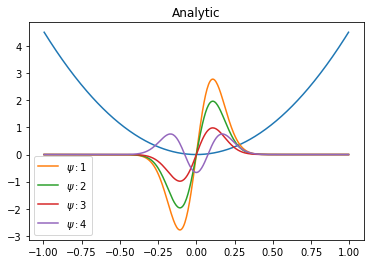

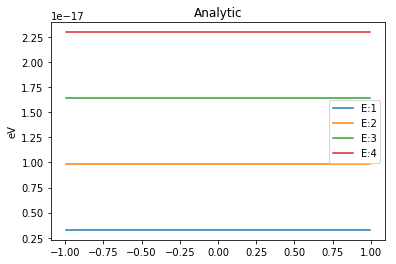

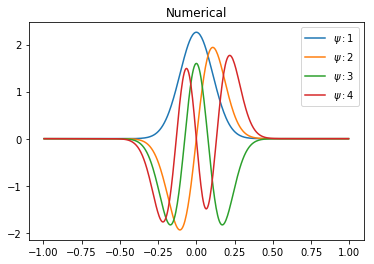

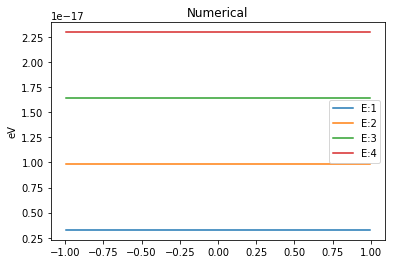

In [379]:
x = np.array([n*dx for n in range(-N,N+1)]) 
omega = 1e-2        #adjust

def hermite_polynomial(n,x):
    h_0 = 1
    h_1 = 2*x
    for i in range(2,n):
        temp = h_1
        h_1 = 2*x*h_1 - 2*(i-1)*h_0
        h_0 = temp    
    return h_1

def psi_HO_an(n,x):
    h_n = hermite_polynomial(n,np.sqrt((m*omega)/h_bar)*x)
    factorial = 1/np.sqrt(2**(n) * np.math.factorial(n))
    exp = np.e**(-(m*omega*x**2)/(2*h_bar))
    fac = (m*omega/(np.pi*h_bar))**(1/4)
    return factorial*h_n*fac*exp 

def E_HO_an(n):
    return ((n+0.5)*h_bar*omega)/1.60e-19      #eV

def V_HO(x):
    return (m*omega**(2) * x**(2))/2


eigenvalues_HO, psi_HO = solve_TUSL(V_HO)
psi_HO = normalize(psi_HO)
print("Harmonic oscillator\n")
print(check_norm_psi(psi_HO[:,0]), "\t Normalized")
print("Comparing numrical eigenvalues")
eigenvalues_ratio(4,eigenvalues_HO)

plt.plot(x,V_HO(x)*1e+35)            #Plots the potential with analytic plot, blue line.
plotting(E_HO_an, psi_HO_an, "Analytic", 4)
plotting(eigenvalues_HO, psi_HO, "Numerical", 4)

## Partikkel i endelige brønnpotensialer

Et tredje velkjent eksempel er enkeltbrønnen
$$V(x) = \begin{cases}
-V_0 & \text{for}\,\, 0 < x < w \\ 
0   & \text{ellers}
\end{cases}$$
med bredde $w$ og brønndybde $V_0 > 0$.
I dette potensialet finnes ingen analytiske løsninger for de bundne stasjonære tilstandenes energiegenverdier.

Enkeltbrønnen kan generaliseres til et potensial bestående av $N_w$ slike enkeltbrønner plassert ved siden av hverandre med en fast avstand $g$ mellom hver brønn.
Med første brønn i $x = 0$, kan vi uttrykke det sammensatte brønnpotensialet stykkevis som

$$V(x) = \begin{cases}
0    & \text{for}\,\, x < 0 \,\, \text{og} \,\, x > N_w (w + g) & \text{(utenfor brønnområdet)} \\
-V_0 & \text{for}\,\, \frac{x}{w+g} - \left\lfloor \frac{x}{w+g} \right\rfloor < \frac{w}{w+g} & \text{(i brønnene)} \\
0    & \text{ellers} & \text{(mellom brønnene)} \\
\end{cases}$$

Dette er en enkel modell for det periodiske potensialet som et elektron opplever i et fast stoff med en regulær krystallinsk struktur, for eksempel et metall.

**Framstill de bundne tilstandene for et elektron både i en enkeltbrønn og i et sammensatt potensial bestående av mange brønner grafisk. Legg inn et passe stort område med $V = 0$ på begge sider av brønnområdet.**

**Hvordan distribueres energinivåene i potensialet bestående av mange brønner sammenlignet med enkeltbrønnen? Kan du ut fra dette forklare hva vi mener med *energibåndstrukturen* til et fast stoff ved hjelp av begrepene *båndbredde* og *båndgap*?**

Single well

0.9751243781094528 	 Normalized
3 bounded states in this potential


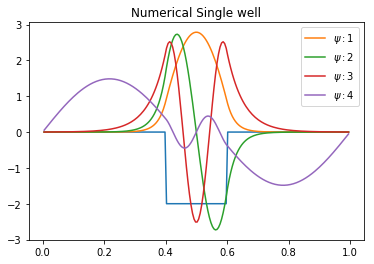

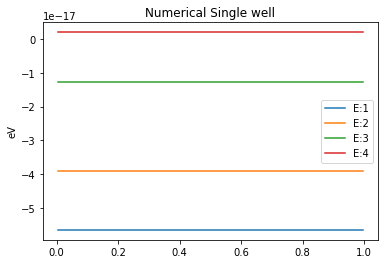

Many wells

0.9751243781094528 	 Normalized


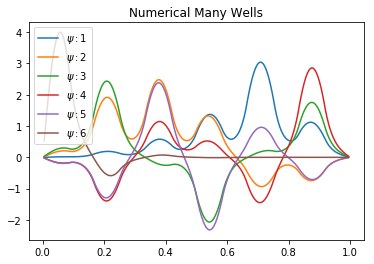

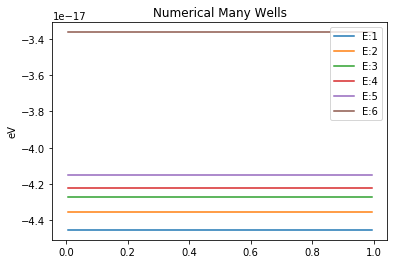

The bandgaps between the energylevels are larger for the single well.


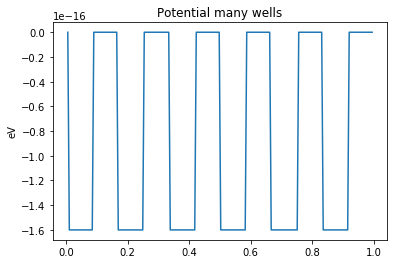

In [22]:
V_0 = 1e-35
w = 0.1    #Wellwidth/2
L = 1
x = [n*dx for n in range(1,N+1)]

def V_single_well(number):
    if L/2-w < number < L/2+w:
        return -V_0
    else: 
        return 0

V_list = [V_single_well(x_i) for x_i in x]
plt.plot(x,np.array(V_list)*2e+35)            #Plots the potential with the analytic, blue line

eigenvalues_SW, psi_SW = solve_TUSL(V_single_well)
psi_SW = normalize(psi_SW)
print("Single well\n")
print(check_norm_psi(psi_SW[:,10]), "\t Normalized")
print("3 bounded states in this potential")
plotting(eigenvalues_SW, psi_SW, "Numerical Single well", 4)

#--------------------------------------------------------------#
L = 1
N_w = 6          #8 wells
g = 0.08        #gap length
w = L/N_w - g 
            
def V_many_wells(x):
    if x == dx:
        return 0
    while x>w+g:
            x-=(w+g)
    if 0.0 <= x <= w:
        return -V_0
    else:
        return 0

eigenvalues_MW, psi_MW = solve_TUSL(V_many_wells)
psi_MW = normalize(psi_MW)
print("Many wells\n")
print(check_norm_psi(psi_MW[:,10]), "\t Normalized")
plotting(eigenvalues_MW, psi_MW, "Numerical Many Wells", 6)
print("The bandgaps between the energylevels are larger for the single well.")

#Plots the potential sperate
V_list = [V_many_wells(x_i) for x_i in x]
plt.plot(x,np.array(V_list)*1.6e+19)
plt.ylabel("eV")
plt.title("Potential many wells")
plt.show()

## Partikkel i Deltabarriere eller Deltabrønn

Et fjerde velkjent eksempel er Deltabrønnen
$$ V(x) = -\alpha \delta(x) $$
der $\delta(x)$ er Diracs deltafunksjon og $\alpha > 0$ er en konstant.
Deltapotensialet er, grovt sagt, ikke annet enn et endelig brønnpotensial der $w \rightarrow 0$ og $V_0 \rightarrow \infty$, men slik at produktet $\alpha = V_0 w$ er endelig.

**Framstill noen energier og energiegenfunksjoner for et elektron i en Deltabrønn grafisk. Approksimér Deltabrønnen som en smal og dyp enkeltbrønn.**

**Hvor mange bundne tilstander ser det ut til å være i Deltabrønnen?**

Delta well

0.9751243781094527 	 Normalized
Only one bounded state in the well.


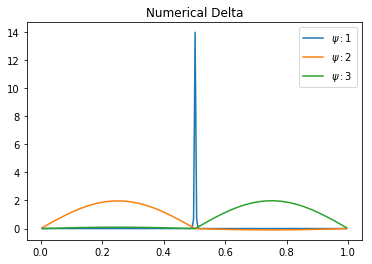

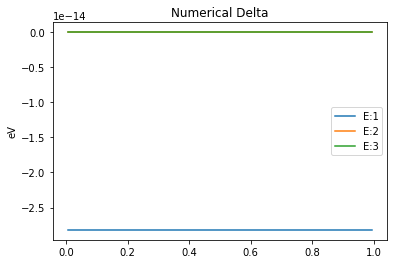

In [381]:
x = [n*dx for n in range(1,N+1)]

V_0 = 1e-30
V_list = [0 for i in range(len(x))]
V_list[int(len(x)/2)] = -dx*V_0    #deltawell

hamilton_diagonal = [h_bar**2/(m*dx**2) + v for v in V_list]
hamilton_semi_diagonal = [-h_bar**2/(2*m*dx**2) for i in range(len(V_list)-1)]
eigenvalues_DW, psi_DW = eigh_tridiagonal(hamilton_diagonal, hamilton_semi_diagonal)
eigenvalues_DW = eigenvalues_DW/(1.60e-19)  #eV

psi_DW = normalize(psi_DW)
print("Delta well\n")
print(check_norm_psi(psi_DW[:,0]), "\t Normalized")
print("Only one bounded state in the well.")
plotting(eigenvalues_DW,psi_DW,"Numerical Delta", 3)

## Avsluttende ord

Implementeringen av den numeriske metoden har nok vært krevende, men vi håper du setter pris på sluttresultatet.
Selv om en hvilken som helst numerisk teknikk nødvendigvis fører med seg numeriske feil og har visse begrensninger, er det på den andre siden forhåpentligvis tilfredsstillende å kunne bruke én generell metode til å utforske så mange problemer.

**Bruk gjerne den numeriske metoden som et verktøy i framtidige situasjoner der det kan være nyttig å få et raskt overblikk over stasjonære tilstander eller energinivåer!**